In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity


class EventCameraEmulator(object):

    def get_events_image(self, image_1, image_2, theta=20, record_off_events=True, register_off_events_as_on=False, use_log_diff=False):
        '''
        Returns an emulated event image from two RGB images.
        This may be extended to be usable with different event emulation strategies.

        Parameters
        ----------
        image_1: numpy.ndarray
            Current RGB image array.
        image_2: numpy.ndarray
            Previous RGB image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.
        use_log_diff: bool
            Enables computing differences in log intensity values (instead of raw intensity values)

        Returns
        -------
        events_image: numpy.ndarray
            Estimated event image array.
        '''
        image_1_gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
        image_2_gray = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

        events_image = self.compute_thresholded_diff(image_1_gray, image_2_gray, theta, record_off_events, register_off_events_as_on, use_log_diff=use_log_diff)

        return events_image

    def compute_thresholded_diff(self, frame, previous_frame, theta=20, record_off_events=True, register_off_events_as_on=False, use_log_diff=False):
        '''
        Performs a custom procedure to compute a thresholded difference between two frames:
         - subtracting two GRAY frames from each other,
         - identifying ON and OFF events as pixels with values greater than theta and values
           less than -theta, respectively
         - emulating an event image by marking ON and OFF events with red and blue in a white frame

        Parameters
        ----------
        frame: numpy.ndarray
            Current GRAY image array.
        previous_frame: numpy.ndarray
            Previous GRAY image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.
        use_log_diff: bool
            Enables computing differences in log intensity values (instead of raw intensity values)

        Returns
        -------
        event_frame: numpy.ndarray
            Estimated event image array.
        '''
        ## Frames must be cast to signed ints before computing diffs
        ## Otherwise, negative numbers wrap around to 255...
        if not use_log_diff:
            diff_frame = frame.astype(int) - previous_frame.astype(int)
        else:
            ## Adding a constant factor avoids the issue of very low intensity values (near black)
            ## leading to very high differences in log values (and thus to noisy events near dark objects):
            diff_frame = np.log(frame.astype(int) + 10) - np.log(previous_frame.astype(int) + 10)

        event_frame = np.zeros((frame.shape[0], frame.shape[1]), dtype='uint8')
        event_frame[diff_frame > theta] = 1
        if record_off_events:
            if register_off_events_as_on:
                event_frame[diff_frame < -theta] = 1
            else:
                event_frame[diff_frame < -theta] = 2

        return event_frame

    def get_ssim_diff_frame(self, image_1, image_2, rounding_threshold=50):
        '''
        Computes the difference between two frames using scikit-image's structural
        similarity index approach.

        Parameters
        ----------
        image_1: numpy.ndarray
            Current RGB image array.
        image_2: numpy.ndarray
            Previous RGB image array.
        rounding_threshold: int
            Pixel filtering threshold. Helps in some noise filtering by setting values that are
            close to white or black to these colors

        Returns
        -------
        diff_frame: numpy.ndarray
            Estimated event image array.
        '''
        score, diff_frame = structural_similarity(image_1, image_2, full=True)
        diff_frame = (diff_frame * 255).astype("uint8")

        diff_frame[diff_frame > (255 - rounding_threshold)] = 255
        diff_frame[diff_frame < (0 + rounding_threshold)] = 0

        return diff_frame

    def get_events_image_rgb(self, image_1, image_2, theta=20, record_off_events=True, register_off_events_as_on=False, use_log_diff=False, method='', blur_images=False):
        '''
        Returns an emulated event image from two RGB images.
        This may be extended to be usable with different event emulation strategies.

        Parameters
        ----------
        image_1: numpy.ndarray
            Current RGB image array.
        image_2: numpy.ndarray
            Previous RGB image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.
        use_log_diff: bool
            Enables computing differences in log intensity values (instead of raw intensity values)

        Returns
        -------
        events_image: numpy.ndarray
            Estimated event image array.
        '''
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
        image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

        if method != '':
            if method == 'salvatore':
                events_image = self.compute_thresholded_diff_salvatore_method(image_1_rgb, image_2_rgb, theta, record_off_events, register_off_events_as_on)
            else:
                raise ValueError('method must be one of [\'salvatore\']')
        else:
            events_image = self.compute_thresholded_diff_rgb_multi_channel(image_1_rgb, image_2_rgb, theta, record_off_events, register_off_events_as_on, use_log_diff, blur_images=blur_images)
        # events_image = self.compute_thresholded_diff_rgb_single_channel(image_1_rgb, image_2_rgb, theta, record_off_events, register_off_events_as_on)


        return events_image

    def compute_thresholded_diff_rgb_multi_channel(self, frame, previous_frame, theta=20, record_off_events=True, register_off_events_as_on=False, use_log_diff=False, blur_images=False, blur_kernel_size=(5,5)):
        '''
        Performs a custom procedure to compute a thresholded difference between two frames:
         - subtracting two RGB frames from each other (optionally using log intensity values),
         - identifying ON and OFF events as pixels with values greater than theta and values
           less than -theta, respectively
         - emulating an event image by marking ON and OFF events with red and blue in a white frame

        Parameters
        ----------
        frame: numpy.ndarray
            Current RGB image array.
        previous_frame: numpy.ndarray
            Previous RGB image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.
        use_log_diff: bool
            Enables computing differences in log intensity values (instead of raw intensity values)

        Returns
        -------
        event_frame: numpy.ndarray
            Estimated event image array.
        '''
        if blur_images:
            # print('[INFO] Blurring image!')
            frame = cv2.blur(frame, blur_kernel_size)
            previous_frame = cv2.blur(previous_frame, blur_kernel_size)

        ## Frames must be cast to signed ints before computing diffs
        ## Otherwise, negative numbers wrap around to 255...
        if not use_log_diff:
            diff_frame = frame.astype(int) - previous_frame.astype(int)
        else:
            ## Adding a constant factor avoids the issue of very low intensity values (near black)
            ## leading to very high differences in log values (and thus to noisy events near dark objects):
            diff_frame = np.log(frame.astype(int) + 10) - np.log(previous_frame.astype(int) + 10)

        theta_frame = np.full((diff_frame.shape[0], diff_frame.shape[1], 3), theta, dtype='uint8')

        ## Find indices of pixels for which R,G,B are all > theta:
        bools = (diff_frame - theta_frame) > 0.
        # Note: If RGB are all True, the sum for a pixel would be 3:
        on_indices = np.sum(bools, 2) == 3.

        ## Find indices of pixels for which R,G,B are all < theta:
        bools = (diff_frame + theta_frame) < 0.
        # Note: If RGB are all True, the sum for a pixel would be 3:
        off_indices = np.sum(bools, 2) == 3.

        event_frame = np.zeros((frame.shape[0], frame.shape[1]), dtype='uint8')
        event_frame[on_indices] = 1
        if record_off_events:
            if register_off_events_as_on:
                event_frame[off_indices] = 1
            else:
                event_frame[off_indices] = 2

        return event_frame

    def compute_thresholded_diff_salvatore_method(self, frame, previous_frame, theta=0.25, record_off_events=True, register_off_events_as_on=False):
        '''
        Performs a procedure to compute a thresholded difference between two frames following the method described in the paper:
        Salvatore, Nikolaus, et al. "A neuro-inspired approach to intelligent collision avoidance and navigation." 2020 AIAA/IEEE 39th Digital Avionics Systems Conference (DASC). IEEE, 2020.

        Parameters
        ----------
        frame: numpy.ndarray
            Current RGB image array.
        previous_frame: numpy.ndarray
            Previous RGB image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.

        Returns
        -------
        event_frame: numpy.ndarray
            Estimated event image array.
        '''
        log_frame = frame.astype('float')
        log_frame[:, :, 0] *= 0.299
        log_frame[:, :, 1] *= 0.587
        log_frame[:, :, 2] *= 0.114
        log_frame = np.log(np.sum(log_frame, axis=2))

        log_previous_frame = previous_frame.astype('float')
        log_previous_frame[:, :, 0] *= 0.299
        log_previous_frame[:, :, 1] *= 0.587
        log_previous_frame[:, :, 2] *= 0.114
        log_previous_frame = np.log(np.sum(log_previous_frame, axis=2))

        diff_frame = log_frame - log_previous_frame

        event_frame = np.zeros((frame.shape[0], frame.shape[1]), dtype='uint8')
        event_frame[diff_frame > theta] = 1
        if record_off_events:
            if register_off_events_as_on:
                event_frame[diff_frame < -theta] = 1
            else:
                event_frame[diff_frame < -theta] = 2

        return event_frame

    def compute_thresholded_diff_rgb_single_channel(self, frame, previous_frame, theta=20, record_off_events=True, register_off_events_as_on=False):
        '''
        Performs a custom procedure to compute a thresholded difference between two frames:
         - subtracting two RGB frames from each other,
         - identifying ON and OFF events as pixels with values greater than theta and values
           less than -theta, respectively
         - emulating an event image by marking ON and OFF events with red and blue in a white frame

        Parameters
        ----------
        frame: numpy.ndarray
            Current RGB image array.
        previous_frame: numpy.ndarray
            Previous RGB image array.
        theta: int
            Threshold value. Smaller values lead to more noisy results.

        Returns
        -------
        event_frame: numpy.ndarray
            Estimated event image array.
        '''
        ## Frames must be cast to signed ints before computing diffs
        ## Otherwise, negative numbers wrap around to 255...
        diff_frame = frame.astype(int) - previous_frame.astype(int)
        theta_frame = np.full((diff_frame.shape[0], diff_frame.shape[1], 3), theta, dtype='uint8')

        ## Find indices of pixels for which R,G,B are all > theta:
        bools = (diff_frame - theta_frame) > 0.
        # Note: If RGB are all True, the sum for a pixel would be 3:
        on_indices = np.sum(bools, 2) >= 1.

        ## Find indices of pixels for which R,G,B are all < theta:
        bools = (diff_frame + theta_frame) < 0.
        # Note: If RGB are all True, the sum for a pixel would be 3:
        off_indices = np.sum(bools, 2) >= 1.

        event_frame = np.zeros((frame.shape[0], frame.shape[1]), dtype='uint8')
        event_frame[on_indices] = 1
        if record_off_events:
            if register_off_events_as_on:
                event_frame[off_indices] = 1
            else:
                event_frame[off_indices] = 2

        return event_frame

    def get_visual_events_image(self, event_frame):
        visual_events_image = np.full((event_frame.shape[0], event_frame.shape[1], 3), 255., dtype='uint8')

        visual_events_image[event_frame == 1] = [255., 0., 0.]
        visual_events_image[event_frame == 2] = [0., 0., 255.]

        return visual_events_image

In [3]:
e_camera_emulator = EventCameraEmulator()
# event_image = e_camera_emulator.get_events_image_rgb(current_image, previous_image)

In [5]:
import os
import cv2

# Total number of folders
# am_rec = 25

# Loop through all the folders
# for k in range(am_rec):
    # Total number of images in each folder
am_imgs = 360

    # Create the output folder for event-{k}
output_folder = f"/content/drive/MyDrive/Robotic Perception Project/event/event-{23}"
os.makedirs(output_folder, exist_ok=True)

previous_image = None  # Initialize previous_image for the first iteration

for idx in range(am_imgs):
        # Load the current image from the folder
        input_path = f"/content/drive/MyDrive/Robotic Perception Project/rectify/rectify-{23}/rectified-img-{idx}.jpg"
        current_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image was successfully loaded
        if current_image is None:
            print(f"Image not found or failed to load: {input_path}")
            continue  # Skip this iteration if the image is missing

        # Process the image (if previous_image exists)
        if previous_image is not None:
            event_image = e_camera_emulator.get_events_image_rgb(
                current_image,
                previous_image,
                30,
                record_off_events=True,
                register_off_events_as_on=False
            )
            visual_event_image = e_camera_emulator.get_visual_events_image(event_image)

            # Save the processed image to the corresponding output folder
            output_path = f"{output_folder}/event-img-{idx}.jpg"
            cv2.imwrite(output_path, visual_event_image)

        # Update previous_image for the next iteration
        previous_image = current_image

print(f"Completed processing for folder {23}")


Completed processing for folder 23


In [ ]:
event_image = e_camera_emulator.get_events_image_rgb(current_image, previous_image, 30,
                                                                 record_off_events=True,
                                                                 register_off_events_as_on=False)

visual_event_image = e_camera_emulator.get_visual_events_image(event_image)

previous_image = current_image
cv2.imwrite("/content/drive/MyDrive/Robotic Perception Project/event/event-img-"+str(idx)+".jpg",visual_event_image)

In [ ]:
from google.colab.patches import cv2_imshow

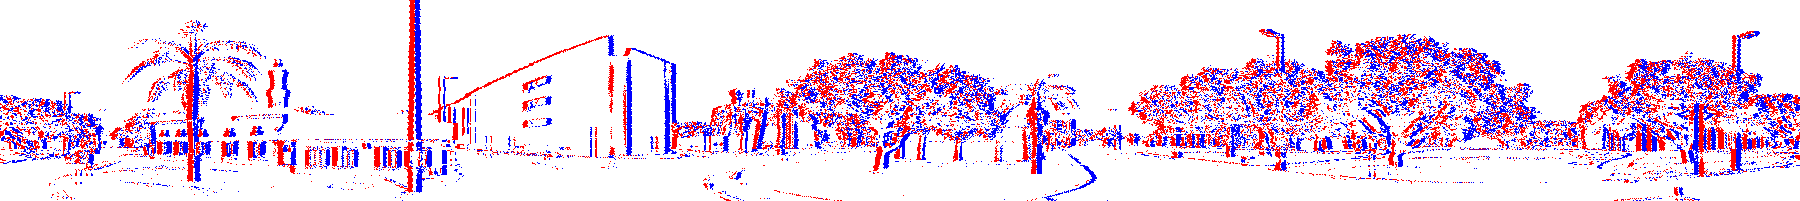

In [ ]:
cv2_imshow(current_image)
cv2_imshow(visual_event_image)
# cv2.waitKey(1)